In [1]:
!pip install patchify

### Imports

In [2]:
import rasterio
import os
import cv2
import shutil
from rasterio.plot import show
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import numpy as np
from sklearn.preprocessing import PowerTransformer

### Reading Tiff Image Files

In [3]:
img1 = rasterio.open('../input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_nrg.tif')
img2 = rasterio.open('../input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_p.tif')

In [4]:
full_img_1 = img1.read()
full_img_2 = img2.read()

### Visualization

In [5]:
_= show(img1)

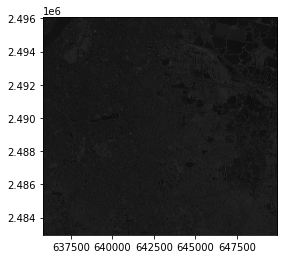

In [6]:
_ = show(img2, cmap = 'gray')

In [7]:
_ = plt.imshow(full_img_2[0],cmap = 'Spectral')

### Image Descriptions

In [8]:
# No. Bands
count1 = img1.count
count2 = img2.count
print('Image 1 bands: {count1} Image 2 bands: {count2}'.format(count1 = count1, count2 = count2))

Image 1 bands: 3 Image 2 bands: 1


In [9]:
img1.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 5049,
 'height': 4681,
 'count': 3,
 'crs': CRS.from_epsg(32645),
 'transform': Affine(2.8, 0.0, 635809.9893442297,
        0.0, -2.8, 2496068.408324141)}

In [10]:
img2.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 20193,
 'height': 18720,
 'count': 1,
 'crs': CRS.from_epsg(32645),
 'transform': Affine(0.7, 0.0, 635809.9893442297,
        0.0, -0.7, 2496067.008324141)}

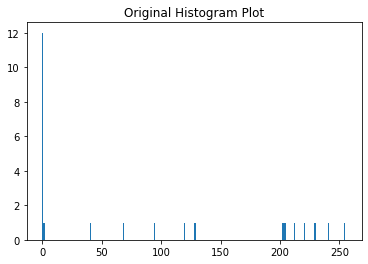

In [13]:
plt.hist(full_img_2.ravel(),256,[0,256])
plt.title('Original Histogram Plot')
plt.show()

### Final High Resolution Image

In [14]:
new_img2 = ((full_img_2 - full_img_2.min()) * (1/(full_img_2.max() - full_img_2.min()) * 255))
new_img2 = new_img2.reshape(new_img2.shape[1],new_img2.shape[2])

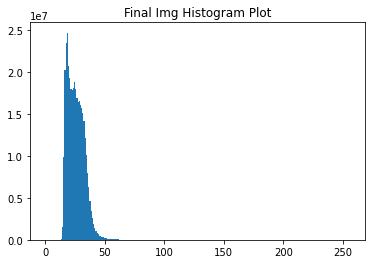

In [15]:
plt.hist(new_img2.ravel(),256,[0,256])
plt.title('Final Img Histogram Plot')
plt.show()

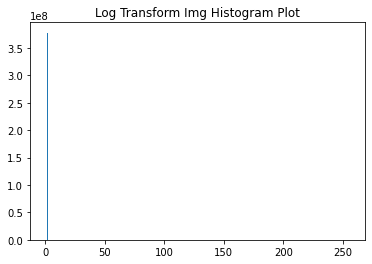

In [16]:
plt.hist(np.log10(new_img2.ravel()+1),256,[0,256])
plt.title('Log Transform Img Histogram Plot')
plt.show()

In [17]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(new_img2,cmap = 'gray')
plt.title('Grayscale')
plt.axis('off')
plt.subplot(122)
plt.imshow(new_img2,cmap = 'Spectral')
plt.axis('off')
_ = plt.title('Spectral')

### Final Low Resolution Image

In [18]:
new_img1_b1 = ((full_img_1[0] - full_img_1[0].min()) * (1/(full_img_1[0].max() - full_img_1[0].min()) * 255))
new_img1_b2 = ((full_img_1[1] - full_img_1[1].min()) * (1/(full_img_1[1].max() - full_img_1[1].min()) * 255))
new_img1_b3 = ((full_img_1[2] - full_img_1[2].min()) * (1/(full_img_1[2].max() - full_img_1[2].min()) * 255))
new_img1_3L = np.stack([new_img1_b1/3,new_img1_b2/3,new_img1_b2/3],axis = 2)
new_img1 = np.mean(new_img1_3L, axis=2)

In [19]:
plt.hist(new_img1.ravel(),256,[0,256])
plt.title('Final Img Histogram Plot')
plt.show()

In [20]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(new_img1,cmap = 'gray')
plt.title('Grayscale')
plt.axis('off')
plt.subplot(122)
plt.imshow(new_img1,cmap = 'Spectral')
plt.axis('off')
_ = plt.title('Spectral')

### Creating Patches (Tiles)

In [21]:
if not os.path.isdir('patches/'):
    os.mkdir('patches/')
    
else:
    shutil.rmtree('patches/')
    os.mkdir('patches/')
    
if not os.path.isdir('patches/lr_image/'):
    os.mkdir('patches/lr_image/')
    

large_image = new_img1

patches_img = patchify(large_image, (64, 64), step=64) 

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('patches/lr_image/' + 'image_' +  '0' + '_' + str(i)+str(j)+ ".tif", single_patch_img)

In [22]:
if not os.path.isdir('patches/hr_image/'):
    os.mkdir('patches/hr_image/')



large_image = new_img2

patches_img = patchify(large_image, (256, 256), step=256)

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('patches/hr_image/' + 'image_' + '0' + '_' + str(i)+str(j)+ ".tif", single_patch_img) 

In [23]:
if not os.path.isdir('patches/lr_image_bands/'):
    os.mkdir('patches/lr_image_bands/')
    
for img in range(new_img1_3L.shape[2]):

    large_image = new_img1_3L[:,:,img]
    
    patches_img = patchify(large_image, (64, 64), step=64) 
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            tiff.imwrite('patches/lr_image_bands/' + 'image_' + str(img) + '_' + str(i)+str(j)+ ".tif", single_patch_img)

### Patches(Tiles) Visualization

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


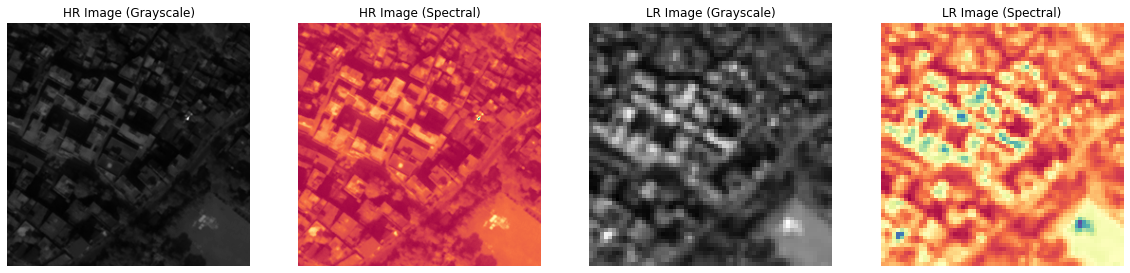

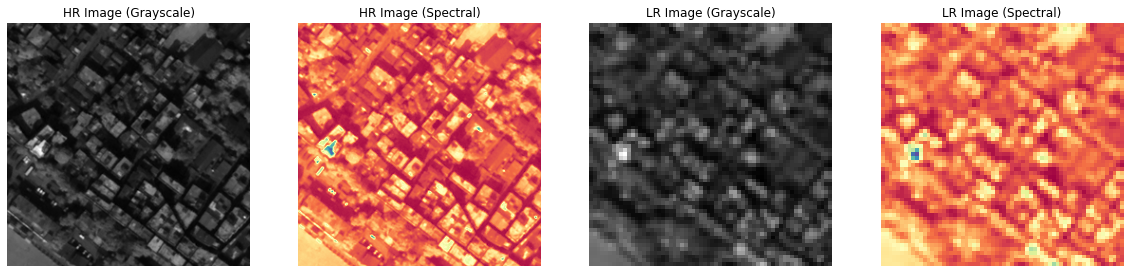

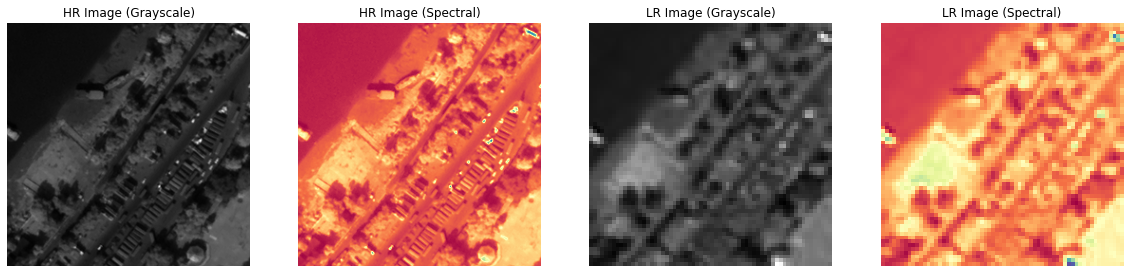

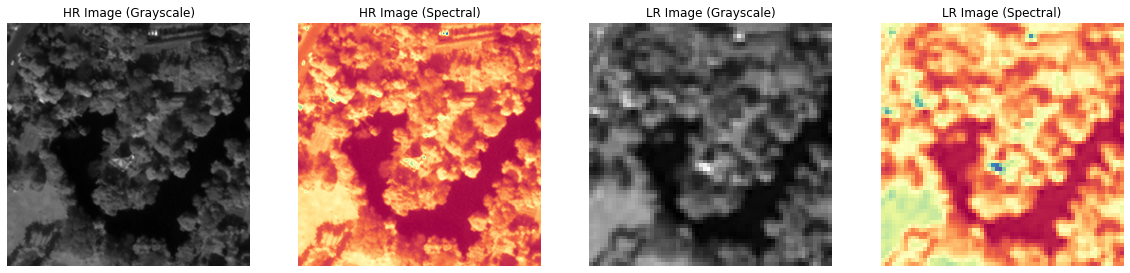

In [24]:
lr_list = os.listdir('patches/lr_image/')
hr_list = os.listdir('patches/hr_image/')
lr_list.sort()
hr_list.sort()

lr_img_array_list = []
hr_img_array_list = []
lr_img_array_list_3L = []

for hr_img in hr_list[0:5]:
    hr_img_open = rasterio.open('patches/hr_image/' + hr_img)
    lr_img_open = rasterio.open('patches/lr_image/' + hr_img)
    lr_img_open_band_1 =  rasterio.open('patches/lr_image_bands/' + hr_img)
    lr_img_open_band_2 =  rasterio.open('patches/lr_image_bands/' + hr_img[:6] + '1' +hr_img[7:])
    lr_img_open_band_3 =  rasterio.open('patches/lr_image_bands/' + hr_img[:6] + '2' +hr_img[7:])  
    hr_img_array = hr_img_open.read()
    lr_img_array = lr_img_open.read()
    lr_img_array_list.append(lr_img_array)
    hr_img_array_list.append(hr_img_array)
    lr_img_array_band_1 = lr_img_open_band_1.read()[0]
    lr_img_array_band_2 = lr_img_open_band_2.read()[0]
    lr_img_array_band_3 = lr_img_open_band_3.read()[0]
    lr_img_array_total = np.stack([lr_img_array_band_1, lr_img_array_band_2, lr_img_array_band_3], axis=2)
    lr_img_array_list_3L.append(lr_img_array_total)
    
    
    fig, axes = plt.subplots(1,4,figsize=(20,20))
    
    ax1 = axes[0]
    ax1.set_axis_off()
    ax1.imshow(hr_img_array[0],cmap = 'gray')
    ax1.set_title('HR Image (Grayscale)')
    
    ax2 = axes[1]
    ax2.set_axis_off()
    ax2.imshow(hr_img_array[0],cmap = 'Spectral')
    ax2.set_title('HR Image (Spectral)')
    
    ax3 = axes[2]
    ax3.set_axis_off()
    ax3.imshow(lr_img_array[0],cmap = 'gray')
    ax3.set_title('LR Image (Grayscale)')
    
    ax4 = axes[3]
    ax4.set_axis_off()
    ax4.imshow(lr_img_array[0],cmap = 'Spectral')
    ax4.set_title('LR Image (Spectral)')
    

    plt.show()


### Downloading Models

In [25]:
# Cloning the EDSR-SRGAN Repo
!git clone https://github.com/krasserm/super-resolution.git

# Downloading the Pre-trained EDSR model
%mkdir EDSR
%cd EDSR
!wget https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz
!tar xvfz weights-edsr-16-x4.tar.gz

# Downloading the Pre-trained EDSR model
%cd ..
%mkdir SRGAN
%cd SRGAN
!wget https://martin-krasser.de/sisr/weights-srgan.tar.gz
!tar xvfz weights-srgan.tar.gz


Cloning into 'super-resolution'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 408 (delta 0), reused 2 (delta 0), pack-reused 405
Receiving objects: 100% (408/408), 48.16 MiB | 29.73 MiB/s, done.
Resolving deltas: 100% (214/214), done.
/kaggle/working/EDSR
--2022-07-15 14:24:52--  https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5653330 (5.4M) [application/gzip]
Saving to: ‘weights-edsr-16-x4.tar.gz’

weights-edsr-16-x4. 100%[===================>]   5.39M  4.56MB/s    in 1.2s    

2022-07-15 14:24:55 (4.56 MB/s) - ‘weights-edsr-16-x4.tar.gz’ saved [5653330/5653330]

weights/
weights/edsr-16-x4/
weights/edsr-16-x4/weights.h5
/kaggle/working
/kaggle/worki

### Imports

In [26]:
import cv2
import numpy as np
import os
import glob
import shutil
import matplotlib.pyplot as plt

### Testing LR and HR Image Segmentation

In [27]:
# lr_dir = 'BSRGAN/testsets/RealSRSet/'
hr_dir = '/OriginalImages/'
# lr_dir = '/LowResImages/'


if not os.path.isdir('/OriginalImages'):
    os.mkdir('/OriginalImages')
else:
    shutil.rmtree(hr_dir)
    os.mkdir('/OriginalImages')
    
# if not os.path.isdir('/LowResImages'):
#     os.mkdir('/LowResImages')
# else:
#     shutil.rmtree('/LowResImages')
#     os.mkdir('/LowResImages')

# if not os.path.isdir('BSRGAN/testsets/RealSRSet'):
#     os.mkdir('BSRGAN/testsets/RealSRSet')
# else:
#     shutil.rmtree(lr_dir)
#     os.mkdir('BSRGAN/testsets/RealSRSet')
    
lr_img_array_list_new = []
for hr_img in hr_list[0:5]:
    hr_img_open = rasterio.open('/kaggle/working/patches/hr_image/' + hr_img)
#     lr_img_open =  rasterio.open('/kaggle/working/patches/lr_image/' + hr_img)
    hr_img_array = hr_img_open.read()
    lr_img_array = lr_img_open.read()[0]
#     lr_img_array_band_2 = lr_img_open_band_2.read()[0]
#     lr_img_array_band_3 = lr_img_open_band_3.read()[0]
#     lr_img_array_total = np.stack([lr_img_array, lr_img_array, lr_img_array], axis=2)
#     lr_img_array_list_new.append(lr_img_array_total)
    cv2.imwrite(hr_dir + hr_img, hr_img_array[0])
#     cv2.imwrite(lr_dir + hr_img, lr_img_array_total)

In [28]:
# if  os.path.isdir('/results'):
#     shutil.rmtree('/results')
# os.mkdir('/results')
images = hr_list[0:5]

### EDSR

In [31]:
lr_imges = np.array(lr_img_array_list).reshape(len(lr_img_array_list),lr_img_array_list[0].shape[1],lr_img_array_list[0].shape[2],lr_img_array_list[0].shape[0])

In [32]:
### EDSR Model
# %cd ..
%cd super-resolution
from model.common import resolve
from model.edsr import edsr
from utils import load_image, plot_sample

model = edsr(scale=4, num_res_blocks=16)

%cd ..
model.load_weights('EDSR/weights/edsr-16-x4/weights.h5')
sr = resolve(model, lr_imges)

/kaggle/working/super-resolution
/kaggle/working


In [33]:
# EDSR Results
if not os.path.isdir('results/'):
    os.mkdir('results/')
results_edsr = 'results/EDSR/'
if not os.path.isdir(results_edsr):
    os.mkdir(results_edsr)

for img,img_array in zip( hr_list[0:5],sr):
    cv2.imwrite(results_edsr + img, img_array.numpy())

### SRGAN

In [ ]:
%cd working

In [ ]:
%cd 

In [34]:
### SRGAN Model
%cd super-resolution
from model.common import resolve
from model.srgan import generator, discriminator
from utils import load_image, plot_sample

pre_generator = generator()
gan_generator = generator()
%cd ..
pre_generator.load_weights('SRGAN/weights/srgan/gan_generator.h5')
gan_generator.load_weights('SRGAN/weights/srgan/pre_generator.h5')
pre = resolve(pre_generator, lr_img_array_list_3L)
gan = resolve(gan_generator, lr_img_array_list_3L)

/kaggle/working/super-resolution
/kaggle/working


In [35]:
# SRGAN Results

results_pre = 'results/PRE/'
results_gan = 'results/GAN/'
if not os.path.isdir(results_gan):
    os.mkdir(results_gan)
    
if not os.path.isdir(results_pre):
    os.mkdir(results_pre)

for img,img_array in zip(images,pre):
    cv2.imwrite(results_pre + img, img_array.numpy())
    
for img,img_array in zip(images,gan):
    cv2.imwrite(results_gan + img, img_array.numpy())

In [ ]:
pre[0].shape

In [ ]:
plt.imshow(pre[0][:,:,1],cmap = 'Spectral')

### Image Visualization

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


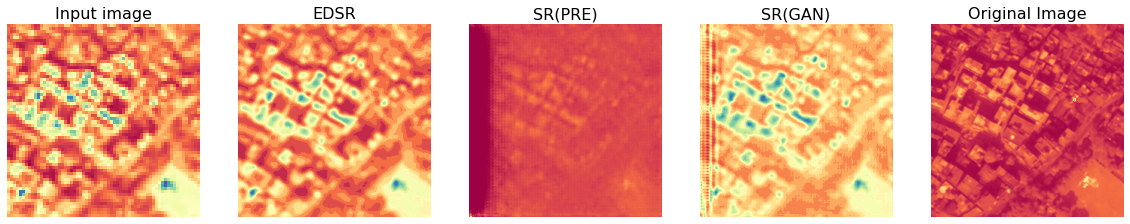

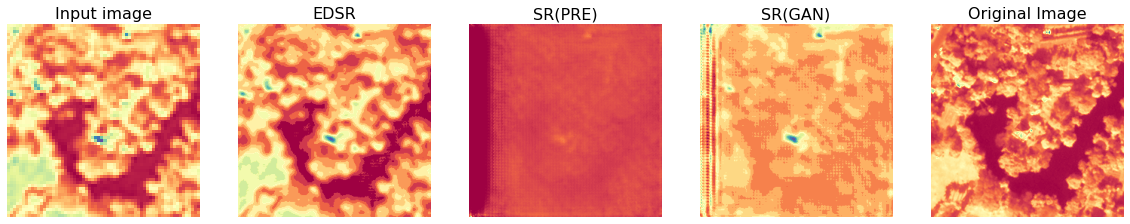

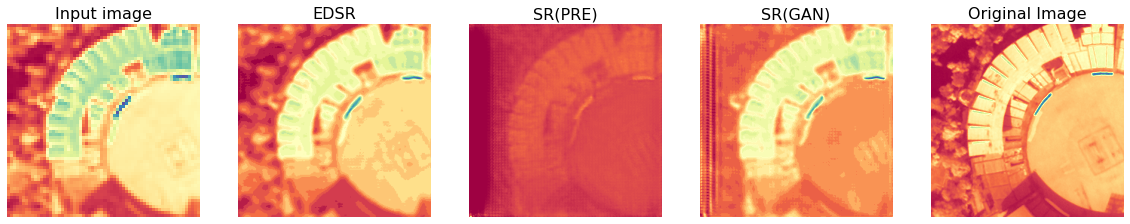

In [36]:
###  Image visualizations

# Display setup
def display(img1,img2,img3,img4, img6):
    
  fig = plt.figure(figsize=(20, 10))

  ax1 = fig.add_subplot(1, 5, 1) 
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 5, 2) 
  plt.title('EDSR', fontsize=16)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, 5, 3)
  plt.title('SR(PRE)', fontsize=16)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, 5, 4)
  plt.title('SR(GAN)', fontsize=16)
  ax4.axis('off')
#   ax5 = fig.add_subplot(1, 5, 5)
#   plt.title('SwinIR Image', fontsize=16)
#   ax5.axis('off')
  ax6 = fig.add_subplot(1, 5, 5)
  plt.title('Original Image', fontsize=16)
  ax6.axis('off')
  ax1.imshow(img1,cmap = 'Spectral')
  ax2.imshow(img2,cmap = 'Spectral')
  ax3.imshow(img3,cmap = 'Spectral')
  ax4.imshow(img4,cmap = 'Spectral')
#   ax5.imshow(img5)
  ax6.imshow(img6,cmap = 'Spectral')

def imread(img_path):
  img = rasterio.open(img_path)
  img = img.read()
  img = img[0]
  return img

# Input and results folder
input_folder =  'patches/lr_image/'
original_folder = '/OriginalImages/'
result_edsr = 'results/EDSR/'
result_presrgan = 'results/PRE/'
result_srgan =  'results/GAN/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    


# Print images
for input_path,original_path,out_edsr,out_pre,out_gan in zip(input_list,original_list,output_edsr,output_presgan,output_srgan):
  img_input = imread(input_path)
  img_original = imread(original_path)
  img_edsr = imread(out_edsr)
  img_pre = imread(out_pre)
  img_gan = imread(out_gan)
#   img_swin = imread(out_swin)
  display(img_input,img_edsr,img_pre,img_gan,img_original)

### Peak Signal-to-Noise Ratio (PSNR) Comperison:

In [40]:
from math import log10, sqrt
import pandas as pd

psnr_list = []

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def psnr(original_img,img_name,img1,img2,img3):
    psnr1 = PSNR(original_img, img1)
    psnr2 = PSNR(original_img, img2)
    psnr3 = PSNR(original_img, img3)
    psnr_list.append([psnr1,psnr2,psnr3])

for input_path,original_path,out_edsr,out_pre,out_gan,img_name in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,images):
  img_input = imread(input_path)
  img_original = imread(original_path)
  img_edsr = imread(out_edsr)
  img_pre = imread(out_pre)
  img_gan = imread(out_gan)
  psnr(img_original,img_name,img_edsr,img_pre,img_gan)
    
df_psnr = pd.DataFrame(psnr_list, columns = ['EDSR','SR(PRE)','SR(GAN)'])
df_psnr['Image']=['Image 1','Image 2','Image 3','Image 4','Image 5']
df_psnr['Avg'] = np.mean(psnr_list,axis = 1)
df_psnr.set_index('Image',inplace = True)
df_psnr.style.set_caption("PSNR Table")

### Structural Similarity Index (SSIM) Comperison:

In [41]:
from skimage.metrics import structural_similarity
score = []

def ssim(original_img,img_name,img1,img2,img3):
    (score1, diff) = structural_similarity(original_img, img1, full=True)
    (score2, diff) = structural_similarity(original_img, img2, full=True)
    (score3, diff) = structural_similarity(original_img, img3, full=True)
    
    score.append([score1,score2,score3])

for input_path,original_path,out_edsr,out_pre,out_gan,img_name in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,images):
  img_input = imread(input_path)
  img_original = imread(original_path)
  img_edsr = imread(out_edsr)
  img_pre = imread(out_pre)
  img_gan = imread(out_gan)
  ssim(img_original,img_name,img_edsr,img_pre,img_gan)
    
df_ssim = pd.DataFrame(score, columns = ['EDSR','SR(PRE)','SR(GAN)'])
df_ssim['Image']=['Image 1','Image 2','Image 3','Image 4','Image 5']
df_ssim['Avg'] = np.mean(psnr_list,axis = 1)
df_ssim.set_index('Image',inplace = True)
df_ssim.style.set_caption("SSIM Table")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  import sys
